<a href="https://colab.research.google.com/github/palashbaranwal/EVA4/blob/master/S6_MNIST/EVA4_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


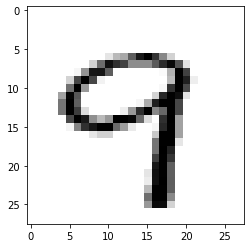

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

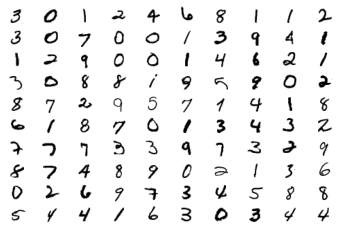

In [6]:
figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #     nn.ReLU()
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 7
         
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # self.convblock9 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1



        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm


class ModelTrain():
  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.valid_loss_min = np.Inf # set initial "min" to infinity
    
  def train(self, model, device, train_loader, optimizer, epoch, scheduler, L1_reg=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)
      
      # Init
      optimizer.zero_grad()
      
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
      
      # Predict
      y_pred = model(data)
      
      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 regularization
      if L1_reg == True:
        L1_factor = 0.000001
        #l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        for param in model.parameters():
          #reg_loss += l1_crit(param)
          reg_loss += torch.sum(param.abs())
        loss += L1_factor * reg_loss
      self.train_losses.append(loss)
      
      # Backpropagation
      loss.backward()
      optimizer.step()
      
      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      
  def test(self, model, device, test_loader,filename):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)
      
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    self.test_acc.append(100. * correct / len(test_loader.dataset))
    
    # save model if validation loss has decreased
    if test_loss <= self.valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          self.valid_loss_min,
          test_loss))
      torch.save(model.state_dict(), filename)
      self.valid_loss_min = test_loss

### Training Model without L1 and L2 Regularization

In [39]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

model1 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model1.train(model, device, train_loader, optimizer, epoch, scheduler)
    model1.test(model, device, test_loader,"model_w.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1431393027305603 Batch_id=468 Accuracy=91.02: 100%|██████████| 469/469 [00:10<00:00, 42.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1074, Accuracy: 9811/10000 (98.11%)

Validation loss decreased (inf --> 0.107437).  Saving model ...
EPOCH: 1


Loss=0.05989636480808258 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:10<00:00, 43.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9863/10000 (98.63%)

Validation loss decreased (0.107437 --> 0.068988).  Saving model ...
EPOCH: 2


Loss=0.09906914085149765 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:10<00:00, 42.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9879/10000 (98.79%)

Validation loss decreased (0.068988 --> 0.046469).  Saving model ...
EPOCH: 3


Loss=0.015995478257536888 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:10<00:00, 42.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9880/10000 (98.80%)

Validation loss decreased (0.046469 --> 0.045479).  Saving model ...
EPOCH: 4


Loss=0.022746941074728966 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:10<00:00, 42.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9895/10000 (98.95%)

Validation loss decreased (0.045479 --> 0.038619).  Saving model ...
EPOCH: 5


Loss=0.01661941409111023 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:11<00:00, 42.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9906/10000 (99.06%)

Validation loss decreased (0.038619 --> 0.032127).  Saving model ...
EPOCH: 6


Loss=0.07542542368173599 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:10<00:00, 43.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.010409727692604065 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:10<00:00, 42.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9914/10000 (99.14%)

Validation loss decreased (0.032127 --> 0.031182).  Saving model ...
EPOCH: 8


Loss=0.006876334547996521 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:10<00:00, 43.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

Validation loss decreased (0.031182 --> 0.022629).  Saving model ...
EPOCH: 9


Loss=0.07467693090438843 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:10<00:00, 42.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.007865275256335735 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 43.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.005598917603492737 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 42.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.05286465957760811 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:10<00:00, 42.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.006114011164754629 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 42.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

Validation loss decreased (0.022629 --> 0.020371).  Saving model ...
EPOCH: 14


Loss=0.006025820970535278 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:10<00:00, 42.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.0020998616237193346 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:10<00:00, 42.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

Validation loss decreased (0.020371 --> 0.018209).  Saving model ...
EPOCH: 16


Loss=0.021946152672171593 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:10<00:00, 42.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.004213059786707163 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:11<00:00, 42.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9919/10000 (99.19%)

EPOCH: 18


Loss=0.007071102503687143 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:11<00:00, 42.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

Validation loss decreased (0.018209 --> 0.017540).  Saving model ...
EPOCH: 19


Loss=0.10784181207418442 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.09965788573026657 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 42.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.02366744540631771 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 42.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.0170303825289011 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:11<00:00, 41.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9939/10000 (99.39%)

Validation loss decreased (0.017540 --> 0.016779).  Saving model ...
EPOCH: 23


Loss=0.022073576226830482 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 42.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.06598671525716782 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:10<00:00, 43.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 25


Loss=0.0022863298654556274 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:10<00:00, 43.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9951/10000 (99.51%)

Validation loss decreased (0.016779 --> 0.016393).  Saving model ...
EPOCH: 26


Loss=0.006739904638379812 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:10<00:00, 43.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9939/10000 (99.39%)

EPOCH: 27


Loss=0.04568156227469444 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:11<00:00, 41.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 9948/10000 (99.48%)

Validation loss decreased (0.016393 --> 0.014862).  Saving model ...
EPOCH: 28


Loss=0.029702549800276756 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:10<00:00, 44.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9948/10000 (99.48%)

EPOCH: 29


Loss=0.0022400219459086657 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:10<00:00, 44.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9949/10000 (99.49%)

EPOCH: 30


Loss=0.0013855894794687629 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:10<00:00, 44.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9946/10000 (99.46%)

EPOCH: 31


Loss=0.007851664908230305 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:10<00:00, 44.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 9954/10000 (99.54%)

Validation loss decreased (0.014862 --> 0.014688).  Saving model ...
EPOCH: 32


Loss=0.004385848995298147 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:10<00:00, 45.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 9948/10000 (99.48%)

EPOCH: 33


Loss=0.008840222842991352 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:10<00:00, 44.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9954/10000 (99.54%)

Validation loss decreased (0.014688 --> 0.014337).  Saving model ...
EPOCH: 34


Loss=0.003179480554535985 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:10<00:00, 44.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9950/10000 (99.50%)

EPOCH: 35


Loss=0.0006465415353886783 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 44.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 9958/10000 (99.58%)

EPOCH: 36


Loss=0.0005745788221247494 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:10<00:00, 44.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9956/10000 (99.56%)

Validation loss decreased (0.014337 --> 0.013986).  Saving model ...
EPOCH: 37


Loss=0.0004091958107892424 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 44.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 9955/10000 (99.55%)

Validation loss decreased (0.013986 --> 0.013799).  Saving model ...
EPOCH: 38


Loss=0.012906541116535664 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:10<00:00, 44.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 9956/10000 (99.56%)

Validation loss decreased (0.013799 --> 0.013377).  Saving model ...
EPOCH: 39


Loss=0.012935061939060688 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:10<00:00, 44.78it/s]



Test set: Average loss: 0.0138, Accuracy: 9954/10000 (99.54%)



### Training model with L1 regularization

In [41]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

model_L1 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_L1.train(model, device, train_loader, optimizer, epoch, scheduler, True)
    model_L1.test(model, device, test_loader,"model_L1.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12024884670972824 Batch_id=468 Accuracy=91.59: 100%|██████████| 469/469 [00:11<00:00, 39.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1091, Accuracy: 9813/10000 (98.13%)

Validation loss decreased (inf --> 0.109103).  Saving model ...
EPOCH: 1


Loss=0.08331333100795746 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9819/10000 (98.19%)

Validation loss decreased (0.109103 --> 0.072172).  Saving model ...
EPOCH: 2


Loss=0.08326657861471176 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:11<00:00, 39.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9859/10000 (98.59%)

Validation loss decreased (0.072172 --> 0.053037).  Saving model ...
EPOCH: 3


Loss=0.05015479028224945 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:11<00:00, 40.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9888/10000 (98.88%)

Validation loss decreased (0.053037 --> 0.042418).  Saving model ...
EPOCH: 4


Loss=0.020688312128186226 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:11<00:00, 40.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.06849732995033264 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 40.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9897/10000 (98.97%)

Validation loss decreased (0.042418 --> 0.037257).  Saving model ...
EPOCH: 6


Loss=0.03187834098935127 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:11<00:00, 40.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9892/10000 (98.92%)

EPOCH: 7


Loss=0.1096300408244133 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:11<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9910/10000 (99.10%)

Validation loss decreased (0.037257 --> 0.030003).  Saving model ...
EPOCH: 8


Loss=0.0487687774002552 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:11<00:00, 40.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.018837131559848785 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:11<00:00, 40.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9867/10000 (98.67%)

EPOCH: 10


Loss=0.013044271618127823 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9926/10000 (99.26%)

Validation loss decreased (0.030003 --> 0.024853).  Saving model ...
EPOCH: 11


Loss=0.06185531243681908 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 39.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.0038359262980520725 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:11<00:00, 39.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.037939656525850296 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

Validation loss decreased (0.024853 --> 0.023526).  Saving model ...
EPOCH: 14


Loss=0.03575769439339638 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

Validation loss decreased (0.023526 --> 0.021956).  Saving model ...
EPOCH: 15


Loss=0.01792393997311592 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:11<00:00, 39.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.008641586638987064 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 39.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

Validation loss decreased (0.021956 --> 0.021502).  Saving model ...
EPOCH: 17


Loss=0.02238440327346325 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

Validation loss decreased (0.021502 --> 0.018996).  Saving model ...
EPOCH: 18


Loss=0.013701136223971844 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:11<00:00, 40.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Loss=0.05903138220310211 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.04916514456272125 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:11<00:00, 39.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Loss=0.004172112792730331 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 39.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.06413669139146805 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:11<00:00, 40.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)

Validation loss decreased (0.018996 --> 0.017815).  Saving model ...
EPOCH: 23


Loss=0.020587220788002014 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:11<00:00, 40.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.00685162004083395 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:11<00:00, 40.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.01456317026168108 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:11<00:00, 39.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

EPOCH: 26


Loss=0.014795142225921154 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:11<00:00, 40.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 27


Loss=0.055084437131881714 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:11<00:00, 40.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 28


Loss=0.014126555994153023 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:11<00:00, 40.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 29


Loss=0.006220434792339802 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9944/10000 (99.44%)

Validation loss decreased (0.017815 --> 0.016289).  Saving model ...
EPOCH: 30


Loss=0.0034605544060468674 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)

EPOCH: 31


Loss=0.0034277159720659256 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 32


Loss=0.0045403684489429 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:11<00:00, 40.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 33


Loss=0.021182363852858543 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:11<00:00, 40.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99.46%)

EPOCH: 34


Loss=0.0028643705882132053 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:11<00:00, 40.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 35


Loss=0.0027964836917817593 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:11<00:00, 39.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9950/10000 (99.50%)

EPOCH: 36


Loss=0.026159290224313736 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:11<00:00, 39.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9953/10000 (99.53%)

EPOCH: 37


Loss=0.00677889259532094 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:12<00:00, 38.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

EPOCH: 38


Loss=0.027101406827569008 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:12<00:00, 38.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9952/10000 (99.52%)

EPOCH: 39


Loss=0.012664839625358582 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]



Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)



### Training model with L2 regularization

In [43]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.000001)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

model_L2 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_L2.train(model, device, train_loader, optimizer, epoch, scheduler)
    model_L2.test(model, device, test_loader,"model_L2.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12899158895015717 Batch_id=468 Accuracy=91.81: 100%|██████████| 469/469 [00:10<00:00, 43.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1101, Accuracy: 9792/10000 (97.92%)

Validation loss decreased (inf --> 0.110095).  Saving model ...
EPOCH: 1


Loss=0.08924371004104614 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:11<00:00, 42.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9882/10000 (98.82%)

Validation loss decreased (0.110095 --> 0.058004).  Saving model ...
EPOCH: 2


Loss=0.07785562425851822 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:10<00:00, 43.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9891/10000 (98.91%)

Validation loss decreased (0.058004 --> 0.044124).  Saving model ...
EPOCH: 3


Loss=0.027097925543785095 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:11<00:00, 42.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9887/10000 (98.87%)

Validation loss decreased (0.044124 --> 0.041406).  Saving model ...
EPOCH: 4


Loss=0.04972623661160469 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:10<00:00, 43.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9882/10000 (98.82%)

Validation loss decreased (0.041406 --> 0.041202).  Saving model ...
EPOCH: 5


Loss=0.03582899272441864 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:10<00:00, 43.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9912/10000 (99.12%)

Validation loss decreased (0.041202 --> 0.029834).  Saving model ...
EPOCH: 6


Loss=0.02389710210263729 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:10<00:00, 43.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)

Validation loss decreased (0.029834 --> 0.028039).  Saving model ...
EPOCH: 7


Loss=0.08795180171728134 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:10<00:00, 43.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.051420360803604126 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:10<00:00, 43.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9924/10000 (99.24%)

Validation loss decreased (0.028039 --> 0.024128).  Saving model ...
EPOCH: 9


Loss=0.06285659968852997 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 42.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

Validation loss decreased (0.024128 --> 0.022722).  Saving model ...
EPOCH: 10


Loss=0.035733576864004135 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:10<00:00, 43.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.0075399428606033325 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)

Validation loss decreased (0.022722 --> 0.022187).  Saving model ...
EPOCH: 12


Loss=0.005559459328651428 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 41.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

Validation loss decreased (0.022187 --> 0.020118).  Saving model ...
EPOCH: 13


Loss=0.04010862484574318 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 43.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.004940410610288382 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:10<00:00, 43.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.07787931710481644 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:10<00:00, 44.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.007064690347760916 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:10<00:00, 44.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.01964792050421238 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:10<00:00, 45.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.0055854967795312405 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:10<00:00, 45.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.056194279342889786 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:10<00:00, 43.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

Validation loss decreased (0.020118 --> 0.019721).  Saving model ...
EPOCH: 20


Loss=0.00872744619846344 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:10<00:00, 45.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

Validation loss decreased (0.019721 --> 0.019327).  Saving model ...
EPOCH: 21


Loss=0.01923372782766819 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:10<00:00, 44.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

Validation loss decreased (0.019327 --> 0.019118).  Saving model ...
EPOCH: 22


Loss=0.0729806125164032 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 44.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

Validation loss decreased (0.019118 --> 0.018449).  Saving model ...
EPOCH: 23


Loss=0.0035215765237808228 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:10<00:00, 44.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.001374557614326477 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 44.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 25


Loss=0.027240872383117676 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:10<00:00, 44.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

EPOCH: 26


Loss=0.014387975446879864 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:10<00:00, 44.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 27


Loss=0.0009515881538391113 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:10<00:00, 43.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.02028004825115204 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:10<00:00, 44.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

EPOCH: 29


Loss=0.0076180994510650635 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:10<00:00, 43.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.01432335376739502 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

Validation loss decreased (0.018449 --> 0.018224).  Saving model ...
EPOCH: 31


Loss=0.004762460943311453 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:10<00:00, 45.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

Validation loss decreased (0.018224 --> 0.017809).  Saving model ...
EPOCH: 32


Loss=0.0029102663975208998 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:10<00:00, 44.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 33


Loss=0.004480535630136728 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:10<00:00, 44.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 34


Loss=0.002741873264312744 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 44.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 35


Loss=0.0033514101523905993 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:10<00:00, 45.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.006202568765729666 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:10<00:00, 45.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 37


Loss=0.0016084164381027222 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:10<00:00, 45.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

EPOCH: 38


Loss=0.0031931649427860975 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:10<00:00, 46.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 39


Loss=0.00203462946228683 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:09<00:00, 47.32it/s]



Test set: Average loss: 0.0185, Accuracy: 9945/10000 (99.45%)



### Training model with both L1 and L2 regularization

In [46]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.000001)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

model_L1_L2 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_L1_L2.train(model, device, train_loader, optimizer, epoch, scheduler, True)
    model_L1_L2.test(model, device, test_loader,"model_L1_L2.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15663211047649384 Batch_id=468 Accuracy=92.06: 100%|██████████| 469/469 [00:10<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Accuracy: 9839/10000 (98.39%)

Validation loss decreased (inf --> 0.090515).  Saving model ...
EPOCH: 1


Loss=0.0883004292845726 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:10<00:00, 43.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9873/10000 (98.73%)

Validation loss decreased (0.090515 --> 0.057020).  Saving model ...
EPOCH: 2


Loss=0.04003361612558365 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:10<00:00, 43.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9811/10000 (98.11%)

EPOCH: 3


Loss=0.12938590347766876 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:11<00:00, 41.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9892/10000 (98.92%)

Validation loss decreased (0.057020 --> 0.043056).  Saving model ...
EPOCH: 4


Loss=0.0387234091758728 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:10<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9883/10000 (98.83%)

Validation loss decreased (0.043056 --> 0.038396).  Saving model ...
EPOCH: 5


Loss=0.10687176138162613 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:10<00:00, 43.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Loss=0.013228391297161579 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:10<00:00, 43.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9901/10000 (99.01%)

Validation loss decreased (0.038396 --> 0.033441).  Saving model ...
EPOCH: 7


Loss=0.006005933042615652 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:11<00:00, 42.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9909/10000 (99.09%)

Validation loss decreased (0.033441 --> 0.033412).  Saving model ...
EPOCH: 8


Loss=0.012705912813544273 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:11<00:00, 42.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9922/10000 (99.22%)

Validation loss decreased (0.033412 --> 0.027579).  Saving model ...
EPOCH: 9


Loss=0.042894840240478516 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 41.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.010025430470705032 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 42.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


Loss=0.02160688117146492 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9925/10000 (99.25%)

Validation loss decreased (0.027579 --> 0.026156).  Saving model ...
EPOCH: 12


Loss=0.0058225663378834724 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:10<00:00, 42.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9926/10000 (99.26%)

Validation loss decreased (0.026156 --> 0.022617).  Saving model ...
EPOCH: 13


Loss=0.013786427676677704 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:10<00:00, 42.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.030677486211061478 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:11<00:00, 41.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.020399145781993866 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:11<00:00, 42.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.010915521532297134 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:11<00:00, 42.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

Validation loss decreased (0.022617 --> 0.021370).  Saving model ...
EPOCH: 17


Loss=0.05481725558638573 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:10<00:00, 42.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.01788792386651039 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:10<00:00, 43.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.017025437206029892 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:10<00:00, 42.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

Validation loss decreased (0.021370 --> 0.020457).  Saving model ...
EPOCH: 20


Loss=0.014204281382262707 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


Loss=0.02751248888671398 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:10<00:00, 42.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.016558930277824402 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:11<00:00, 41.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

Validation loss decreased (0.020457 --> 0.017905).  Saving model ...
EPOCH: 23


Loss=0.008340572007000446 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:11<00:00, 41.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9925/10000 (99.25%)

EPOCH: 24


Loss=0.013696394860744476 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:11<00:00, 41.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9936/10000 (99.36%)

EPOCH: 25


Loss=0.006651211064308882 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:12<00:00, 38.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Loss=0.029359959065914154 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:11<00:00, 39.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 27


Loss=0.008754457347095013 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:11<00:00, 39.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99.49%)

EPOCH: 28


Loss=0.014019750989973545 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:11<00:00, 39.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

EPOCH: 29


Loss=0.002477903850376606 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:11<00:00, 42.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)

Validation loss decreased (0.017905 --> 0.017299).  Saving model ...
EPOCH: 30


Loss=0.04098246246576309 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9940/10000 (99.40%)

EPOCH: 31


Loss=0.004886278882622719 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:10<00:00, 43.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9953/10000 (99.53%)

Validation loss decreased (0.017299 --> 0.015236).  Saving model ...
EPOCH: 32


Loss=0.003978436812758446 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:10<00:00, 43.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)

EPOCH: 33


Loss=0.010205049067735672 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:10<00:00, 43.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)

EPOCH: 34


Loss=0.007236524019390345 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:11<00:00, 41.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


Loss=0.014223040081560612 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 43.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9947/10000 (99.47%)

EPOCH: 36


Loss=0.00277619413100183 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:11<00:00, 42.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9949/10000 (99.49%)

EPOCH: 37


Loss=0.005343049764633179 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:10<00:00, 44.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9950/10000 (99.50%)

EPOCH: 38


Loss=0.02330629527568817 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:10<00:00, 42.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9953/10000 (99.53%)

EPOCH: 39


Loss=0.051408443599939346 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:10<00:00, 44.36it/s]



Test set: Average loss: 0.0160, Accuracy: 9953/10000 (99.53%)



# Plotting validation accuracy of all 4 models

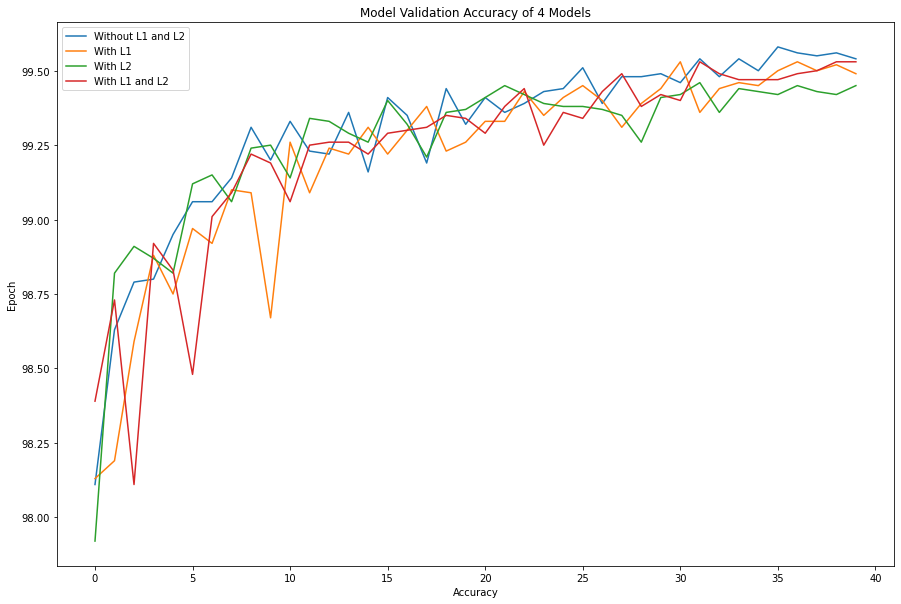

In [48]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1.test_acc)
ax.plot(model_L1.test_acc)
ax.plot(model_L2.test_acc)
ax.plot(model_L1_L2.test_acc)
ax.set(title="Model Validation Accuracy of 4 Models", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Without L1 and L2', 'With L1', 'With L2', 'With L1 and L2'], loc='best')
plt.savefig("Accuracyof4models.png")
plt.show()


In [0]:
### Plotting validation loss of four models

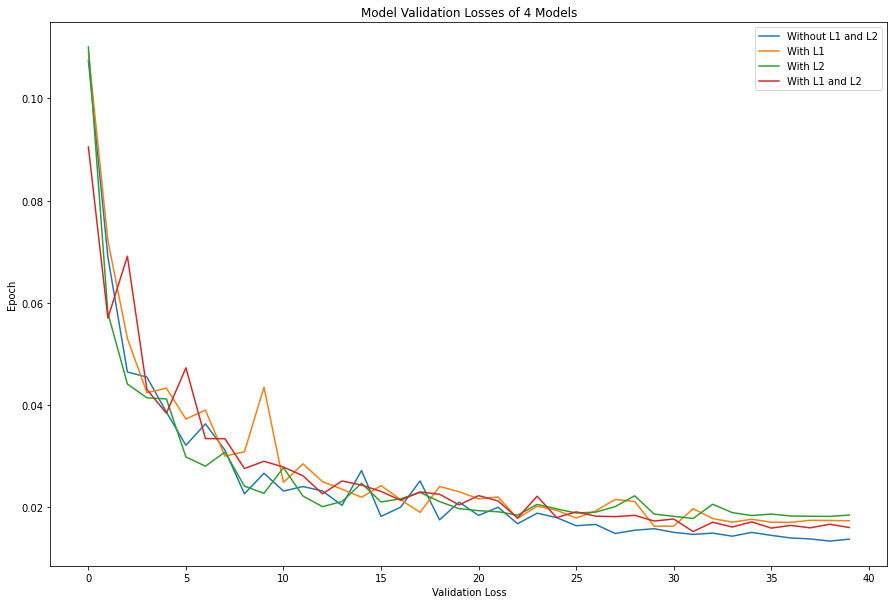

In [49]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1.test_losses)
ax.plot(model_L1.test_losses)
ax.plot(model_L2.test_losses)
ax.plot(model_L1_L2.test_losses)
ax.set(title="Model Validation Losses of 4 Models", xlabel="Validation Loss", ylabel="Epoch")
ax.legend(['Without L1 and L2', 'With L1', 'With L2', 'With L1 and L2'], loc='best')
plt.savefig("ValidationLossof4models.png")
plt.show()

### Function to plot misclassified Images 

In [0]:
def PlotMisclassifiedImages(model, filename):
  
  model = model.to(device)
  # obtain one batch of test images
  dataiter = iter(test_loader)
  c=0
  fig = plt.figure(figsize=(14,14 ))
  
  while c<25:
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    
    output = model(images)  # get sample outputs

    _, preds = torch.max(output, 1)   # convert output probabilities to predicted class
    images = images.cpu().numpy() # prep images for display
    
    for idx in np.arange(128):
      if preds[idx]!=labels[idx] :
        ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
        c=c+1
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("P-{} (T-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
        if c==25:
          break
    plt.savefig(filename)



### Misclaassified images by model1 (without L1 and L2 regularization)

----Misclassified images by a Model without L1 and L2 regualatization----


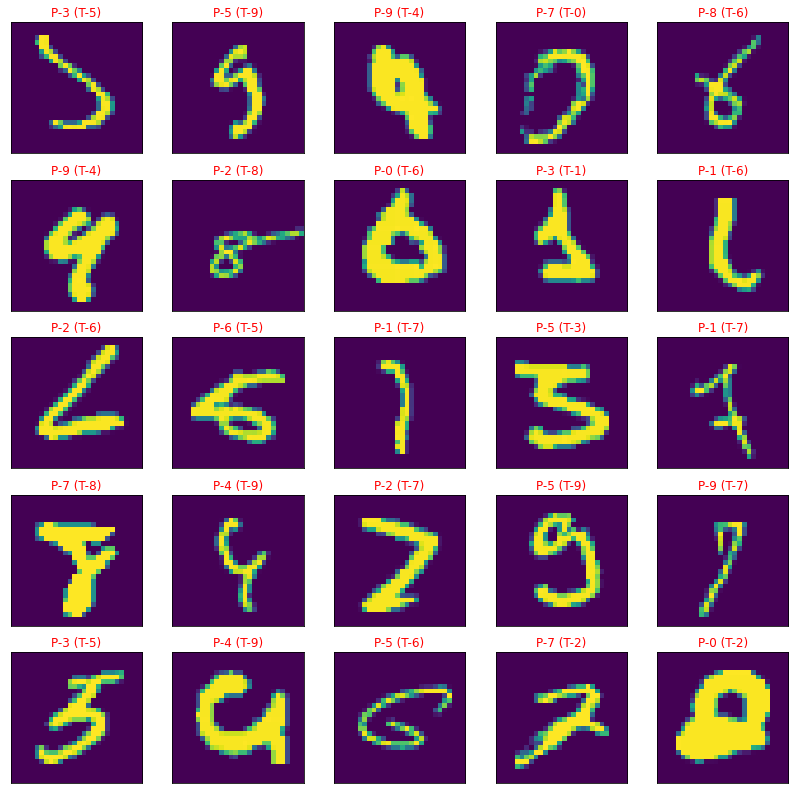

In [40]:
model.load_state_dict(torch.load("model_w.pt")) 
PlotMisclassifiedImages(model, filename="WithoutL1andL2.png")  #25 misclassified images and save it in a file.

### Misclaassified images by model2 (with L1 regularization)

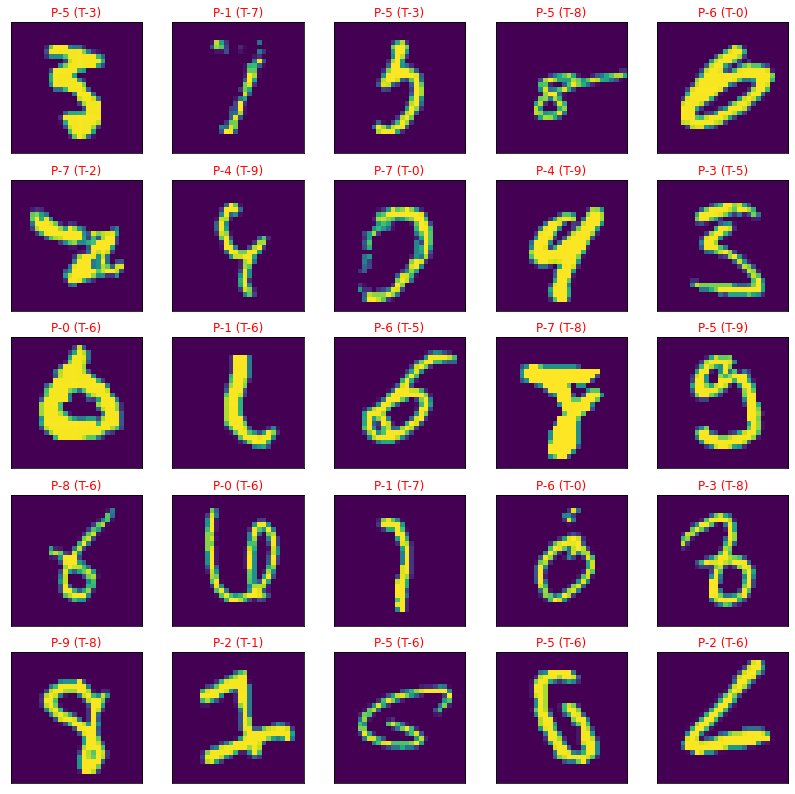

In [42]:
model.load_state_dict(torch.load("model_L1.pt")) 
PlotMisclassifiedImages(model, filename="WithL1.png")  #25 misclassified images and save it in a file.

### Misclaassified images by model3 (with L2 regularization)

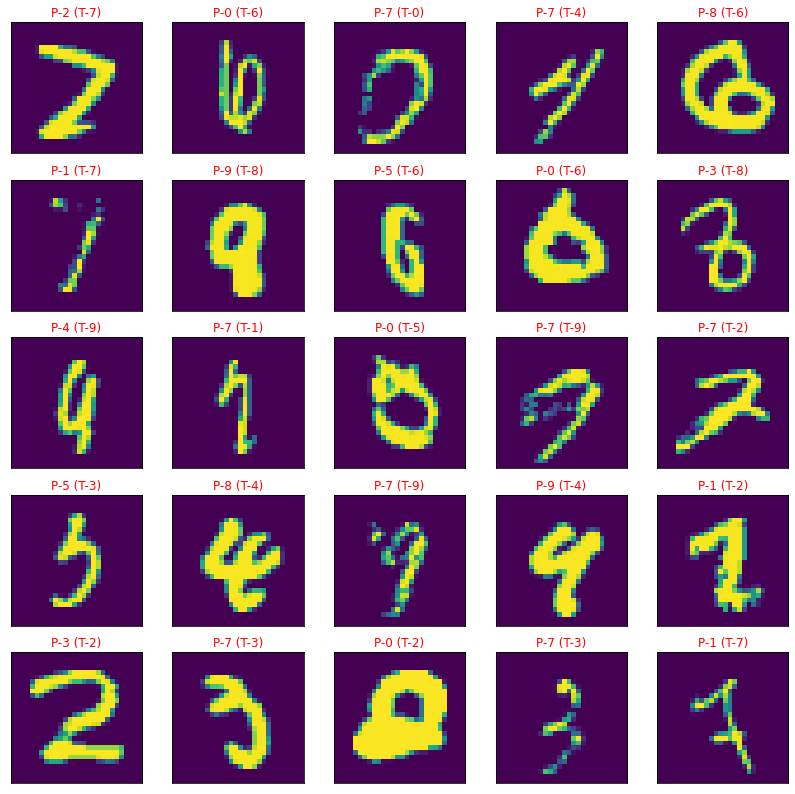

In [45]:
model.load_state_dict(torch.load("model_L2.pt")) 
PlotMisclassifiedImages(model, filename="WithL2.png")  #25 misclassified images and save it in a file.

### Misclaassified images by model4 (with L1 and L2 regularization)

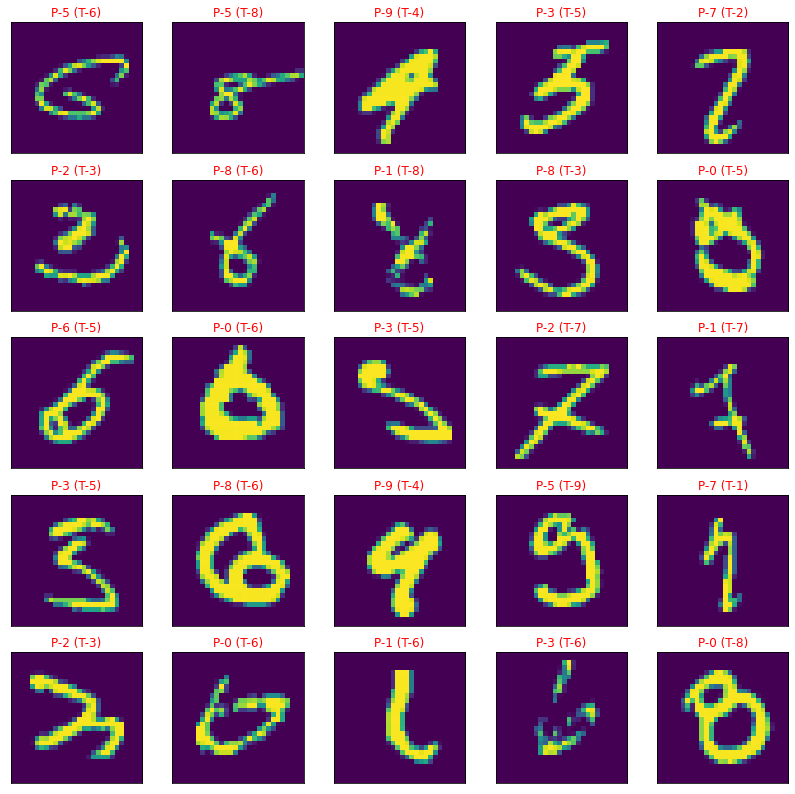

In [47]:
model.load_state_dict(torch.load("model_L1_L2.pt")) 
PlotMisclassifiedImages(model, filename="WithL1L2.png")  #25 misclassified images and save it in a file.